In [2]:
import pandas as pd
import numpy as np
import pickle
import itertools
import re
from typing import List, Tuple, Dict
import operator
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
from functools import reduce
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
%matplotlib inline

In [2]:
# Set max columns displayed to 500
pd.set_option('display.max_columns', 500)

In [3]:
def np_equal(list1, list2):
    """Return a boolean list of whether 2 elements of the same index are equal in the two given lists"""
    return [x == y for x,y in zip(list1,list2)]

In [4]:
def any_equal(list1, value):
    """Return a boolean list of whether any elements of the given list are equal to the given value"""
    return [x == value for x in list1]

In [5]:
def mult_col_search(df: pd.DataFrame, columns: List[str], 
                    string: str, strict: bool = False) -> Tuple[List[bool], List[np.ndarray]]:
    '''Given a set of dataframe columns, which rows and columns return the substring'''
    if strict:
        col_bool = [df[col]==string for col in columns]
    else:
        col_bool = [df[col].str.contains(string) for col in columns]
    bool_mask = np.dstack(col_bool).squeeze()
    rows = [row.any() for row in bool_mask]
    cols = list(itertools.compress(columns, [c.any() for c in col_bool]))
    return rows, cols

In [6]:
def has_state(loc: str) -> bool:
    '''See if a US state name is in location string'''
    return any((state in loc) & (len(loc.split(','))<3) for state in states)
def has_uni(loc: str) -> bool:
    '''See if any college terms are in location string'''
    return any(re.match(college, loc) 
               for college in [r'(?!.*Park)(?=.*College)^(.*)$', 
                               r'.*University.*', r'.*Tech.*',
                               r'.* State'])
def has_the(loc: str) -> bool:
    '''See if the word "The" is in the beginning of the location string'''
    return re.match(r'^[tT]he .*$', loc)

In [7]:
def name_order2(list1, list2, df_index=0):
    list1 = list(enumerate(list1))
    list2 = list(enumerate(list2))
    l1_len = len(list1)
    if l1_len != len(list2):
        raise ValueError('List lengths must be equal')
    indices = [-1]*l1_len
    for i,x in list1:
        if i > 2*l1_len: raise ValueError('Caught in infinite loop')
        occurrences = sum(x in name[1] for name in list2)
        if occurrences == 0:
            raise ValueError('{} is not in list. Show number = {}'.format(x, df_index))
        elif occurrences > 1:
            list1.append((i,x))
        else:
            indices[next(j for j,n in list2 if x in n)] = i
            l2_ix = next(j for j,n in enumerate(list2) if x in n[1])
            del list2[l2_ix]
    return indices

In [8]:
def name_order(list1, list2, df_index=0):
    l1 = list1.copy()
    l2 = list(enumerate(list2))
    l1_len = len(l1)
    indices = [-1]*l1_len
    if l1_len != len(l2):
        raise ValueError('List lengths must be equal')
    for i,x in enumerate(l1):
        if i > 2*l1_len: raise ValueError('Caught in infinite loop')
        occurrences = sum(x in name[1] for name in l2)
        if occurrences == 0:
            raise ValueError('{} is not in list. Show number = {}'.format(x, df_index))
        elif occurrences > 1:
            l1.append(x)
        else:
            if i >= l1_len: i = indices.index(-1)
            indices[i] = next(j for j,n in l2 if x in n)
            l2_ix = next(j for j,n in enumerate(l2) if x in n[1])
            del l2[l2_ix]
    return indices

In [9]:
def word_increases(word_freqs: Dict[str, int], step_size: int=1, 
                   end_step_size: int=None) -> List[Tuple[str, str, int]]:
    '''Tries to find word increases over time
    '''
    if end_step_size is None:
        end_step_size = step_size
    count = len(next(iter(word_freqs.values())))
    next_iteration_diff = defaultdict(lambda : [[[]]]*(end_step_size + 1 - step_size))
    for step in range(step_size, end_step_size+1):
        for key, value in word_freqs.items():
            next_iteration_diff[key][step-1] = next_iteration_diff[key][step-1] + [step]
            for i in range(0, count-step):
                next_iteration_diff[key][step-1][0] = next_iteration_diff[key][step-1][0] + [value[i+step]-value[i]]
    most_freq_diffs = {word: max([(max(it[0]), "between {} and {}".format(it[0].index(max(it[0]))+1,
                                                                            it[0].index(max(it[0]))+it[1]+1),
                                   it[1]) for it in freq], key=lambda x:x[0]) 
                       for word, freq in next_iteration_diff.items()}    
    return sorted(most_freq_diffs.items(), key=lambda x: x[1][0], reverse=True)

In [9]:
#Contestant information dataframe
contestants = pd.read_csv('contestants.txt', header=None, sep='\|\|', error_bad_lines=True,
                     names = ['show_num','date','comments','c1', 'c1_job', 'c1_loc', 'c2', 
                              'c2_job', 'c2_loc', 'c3', 'c3_job', 'c3_loc', 'c4', 'c4_job', 'c4_loc'], 
                     engine='python')

In [10]:
contestants.fillna("", inplace=True)

#Keep to only first names for easier matching
for i in range(1,5):
    #contestants['c'+str(i)] = [re.findall('^([\w"]+)?', name)[0] for name in contestants['c'+str(i)]]
    contestants['c{}_loc'.format(i)] = [loc.strip() for loc in contestants['c{}_loc'.format(i)]]

#Make super jeopardy show numbers unique
superjep_filter = contestants['comments'].str.contains('Super Jeopardy')
#contestants = contestants[~superjep_filter]
contestants.loc[superjep_filter ,'show_num'] = [i + 10000 for i in contestants.loc[superjep_filter ,'show_num']]
#Make super jeopardy show numbers unique
pilot_filter = contestants['comments'].str.contains('Trebek pilot')
contestants.loc[pilot_filter ,'show_num'] = [i + 20000 for i in contestants.loc[pilot_filter ,'show_num']]

In [11]:
#Question dataframe
reader = pd.read_csv('jeopardy_questions.txt', header=None, sep='\|\|', error_bad_lines=True,
                     names = ['season','show_num','question_num','round', 'category', 'difficulty', 
                              'question', 'answer', 'DD', 'c1', 'c1_add', 'c2', 'c2_add', 'c3', 'c3_add', 
                              'c4', 'c4_add'], 
                     engine='python', chunksize = 1000)
episodes = pd.concat([chunk for chunk in reader], ignore_index=True)

In [12]:
for i in range(1,5):
    episodes['c'+str(i)].fillna("", inplace=True)
    episodes['c{}_add'.format(i)].fillna(0, inplace=True)
    episodes['c'+str(i)] = [re.findall('^([\w" ]+)?', name)[0] for name in episodes['c'+str(i)]]
    
#Make super jeopardy show numbers unique
superjep_filter = episodes['season']=='superjeopardy'
#episodes = episodes[~superjep_filter]
episodes.loc[superjep_filter ,'show_num'] = [i + 10000 for i in episodes.loc[superjep_filter ,'show_num']]
#Make Trebek Pilot show numbers unique
pilot_filter = episodes['season']=='trebekpilots'
episodes.loc[pilot_filter ,'show_num'] = [i + 20000 for i in episodes.loc[pilot_filter ,'show_num']]

In [13]:
episodes = episodes[(episodes['season'] != 'superjeopardy') & (episodes['season'] != 'trebekpilots')]

In [14]:
#filter for seeing if any episodes have contestants with the same first name
name_columns = ['c1', 'c2', 'c3',]
first_names = [[name.split(' ')[0] for name in 
                episodes[contestant]] for contestant in 
               name_columns]
same_names = [any(names) for names in 
              zip(*[np_equal(*name_couple) for name_couple in 
                    itertools.combinations(first_names, 2)])]

In [15]:
num_names = [[len(name.split(' ')) for name in episodes[contestant]] for contestant in name_columns]
two_name_indices = [i for contestant in num_names for i,x in enumerate(contestant) if x>1]

In [16]:
#question dataframe (qdf) name corrections
qdf_name_changes = {(61, 'c2'): 'Daniel', (62, 'c2'): 'Daniel', (63, 'c1'): 'Daniel', (191, 'c2'): 'Michael',
                    (308, 'c1'): 'Paul Croshier', (690, 'c2'): 'Denny', (712, 'c3'): 'Chloe', (789, 'c1'): 'Ernest', 
                    (789, 'c2'): 'Christine', (804, 'c2'): 'David Javerbaum', (805, 'c2'): 'David Javerbaum', 
                    (829, 'c1'): 'Arthur', (834, 'c3'): 'Michael', (834, 'c2'): 'Daniel', 
                    (842, 'c1'): 'Dorothy', (1245, 'c3'): 'Steven', (1246, 'c3'): 'Steven', (1286, 'c3'): 'Mary', 
                    (1635, 'c1'): 'Vincent', (2574, 'c1'): 'Charles', (2575, 'c3'): 'Thomas', (2926, 'c1'): 'Rob', 
                    (2929, 'c1'): 'Benjamin',(3023, 'c2'): 'Jimmy', (3124, 'c2'): 'Bob', (3123, 'c2'): 'Bob', 
                    (3125, 'c2'): 'Bob', (3756, 'c3'): 'Sandra', (3757, 'c3'): 'Benjamin', (3757, 'c1'): 'Anastasia',
                    (4520, 'c3'): 'Scott', (4521, 'c1'): 'Scott', (4519, 'c2'): 'Scott', (4522, 'c2'): 'Scott',
                    (4523, 'c2'): 'Scott', (4608, 'c3'): 'Scott', (4647, 'c2'): 'Christina', (5097, 'c3'): 'Ozgun',
                    (5104, 'c2'): 'Brian', (5110, 'c2'): 'Jacob', (5716, 'c1'): 'Francois',
                    (5717, 'c1'): 'Francois', (5718, 'c2'): 'Francois', (5772, 'c2'): 'Debra', (6432, 'c2'): 'Injee',
                    (6179, 'c3'): 'Andrew', (6380, 'c2'): 'Thomas', (6934, 'c1'): 'Che', 
                    (7301, 'c2'): 'Jonathan', (7301, 'c3'): 'S.E.', (7437, 'c2'): 'Rebecca',}

In [17]:
for key in qdf_name_changes:
    episodes.loc[episodes['show_num']==key[0], key[1]] = qdf_name_changes[key]

In [18]:
for i in range(1,5):
    contestants.loc[:,'c{}_add'.format(i)] = 0

In [19]:
episodes = pd.merge(episodes,
                        contestants, 
                        on='show_num', 
                        suffixes=['_y',''])

In [20]:
df2_name_filter = ['c{}_y'.format(i) for i in range(1,4)]
df1_name_filter = ['c{}'.format(i) for i in range(1,4)]
episode_df2_slice = episodes[df2_name_filter].copy()

In [21]:
df2_correct_order = [name_order2(list(ep[df2_name_filter].values), list(ep[df1_name_filter].values), i) 
                     for i,ep in episodes.iterrows()]

In [22]:
add_columns = ['c{}_add'.format(x) for x in range(1,4)]
episodes.loc[:,add_columns] = [[episodes.loc[i,'c{}_add_y'.format(df2_i+1)] for df2_i in order] 
                               for i,order in enumerate(df2_correct_order)]
episodes.drop(['c{}_y'.format(i) for i in range(1,4)], axis=1, inplace=True)
episodes.drop(['c{}_add_y'.format(i) for i in range(1,4)], axis=1, inplace=True)

In [23]:
episodes.to_csv('episode_debugging_df_saved.csv', sep='¤')

In [93]:
episodes = pd.read_csv('episode_debugging_df_saved.csv', sep='¤', engine='python')
episodes.drop('Unnamed: 0', axis=1, inplace=True)
episodes.sort_values('show_num', inplace=True)

In [94]:
episodes['weekday'] = [date.split(',')[0] for date in episodes['date']]

In [95]:
episodes['date'] = [date.split(',',1)[1] for date in episodes['date']]

In [96]:
episodes['date'] = pd.to_datetime(episodes['date'])
episodes['season'] = pd.to_numeric(episodes['season'])
episodes['round'] = pd.Categorical(episodes['round'], ['jeopardy_round', 'double_jeopardy_round', 'final_jeopardy_round'])

In [97]:
episodes.loc[:, episodes.columns != 'round'] = episodes.loc[:, episodes.columns != 'round'].replace(np.nan, '', regex=True)

In [102]:
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 
          'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 
          'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 
          'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 
          'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 
          'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 
          'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 
          'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 
          'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 
          'Wyoming']

In [103]:
state_errors = {'Missouri': ['Missiouri',], 'Virginia': ['Vriginia',], 'Kentucky': ['Kenrucky',], 
               'Illinois': ['Ilinois', 'IL',], 'Massachusetts': ['Masachusetts',], 
               'California': ['Caifornia',], 'Ohio': ['Onio',], 'New York': ['New Nork',],
               'Delaware': ['Deleware',], 'Indiana': ['Indinia',], 'Nevada': ['Nevade',],
               'Wyoming': ['Wyoming and Montana',],
               }

In [104]:
for state in state_errors:
    for error in state_errors[state]:
        episodes.loc[mult_col_search(episodes, ['c{}_loc'.format(i) for i in range(1,4)], error)] = \
        [[string.replace(error, state) for string in question]
        for question in episodes.loc[mult_col_search(episodes, ['c{}_loc'.format(i) 
                                                                for i in range(1,4)], error)].values]

In [90]:
city_errors = dict(**{',{}'.format(state): state for state in states},
                   **{'New York City, New York': 'New York,New York', 
                      'New York City, New York': 'New York City',
                      'Kansas City, Missouri': 'Kansas City',
                      ', Texas': 'North Texas', 
                      ', New York': 'Trinidad and Tobago and now in New York',
                      'Easton, Maryland': 'Easton Maryland',
                      'Lynn, Massachusetts': 'Lynn Massachusetts',
                      })

In [117]:
for city in city_errors:
    episodes.loc[mult_col_search(episodes, ['c{}_loc'.format(i) for i in range(1,4)], 
                                 city_errors[city], strict=True)] = \
    [[city if string==city_errors[city] else string for string in question]
    for question in episodes.loc[mult_col_search(episodes, ['c{}_loc'.format(i) for i in range(1,4)], 
                                                 city_errors[city], strict=True)].values]

In [119]:
for i in range(1,4):
    episodes['c{}_state'.format(i)] = [loc.split(',')[1].strip() 
                                       if (has_state(loc) and not any([has_uni(loc),has_the(loc)])) 
                                       else '' if loc=='' 
                                       else 'Other'  
                                       for loc in episodes['c{}_loc'.format(i)]]

In [120]:
state_counts = dict(zip(*np.unique(episodes.groupby('show_num').first()[['c{}_state'.format(i) 
                                                                        for i in range(1,4)]], return_counts=True)))

In [121]:
unique_categories = list(zip(*np.unique(np.concatenate(list(episodes.groupby('show_num').category.unique())), return_counts=True)))

In [122]:
unique_categories.sort(key=operator.itemgetter(1), reverse=True)

In [1147]:
#episodes.set_index(['season', 'show_num', 'round'], inplace=True)
#episodes.sort_index(inplace=True)

In [1153]:
#episodes.reset_index(inplace=True)

In [522]:
#episodes.drop(labels = ['winner', 'winner_locs', 'winner_winnings'], axis=1, inplace=True)

In [123]:
for i in range(1,5):
    episodes['c{}_cumsum'.format(i)] = episodes.groupby('show_num')['c{}_add'.format(i)].transform(pd.Series.cumsum)

In [124]:
winner = episodes.groupby('show_num').last()[['c1_cumsum','c2_cumsum', 'c3_cumsum']].idxmax(axis=1)

In [125]:
winner = pd.DataFrame([[i, x[:2]] for i,x in zip(winner.index, winner)], columns = ['show_num', 'winner'])

In [126]:
winner_winnings = episodes.groupby('show_num').last()[['c1_cumsum','c2_cumsum', 'c3_cumsum']].max(axis=1)

In [127]:
winner_winnings = pd.DataFrame([[i, x] 
                                for i,x in zip(winner_winnings.index, winner_winnings)], 
                               columns = ['show_num', 'winner_winnings'])

In [128]:
episodes = pd.merge(episodes,
                    winner, 
                    on='show_num', 
                    suffixes=['','_y'])

In [129]:
episodes = pd.merge(episodes,
                    winner_winnings, 
                    on='show_num', 
                    suffixes=['','_y'])

In [130]:
winner_locs = [episodes[contestant+'_loc'].iloc[i]
                 for i, contestant in enumerate(episodes['winner'])]

In [131]:
episodes['winner_loc'] = winner_locs

In [132]:
winner_states = [episodes[contestant+'_state'].iloc[i]
                 for i, contestant in enumerate(episodes['winner'])]

In [133]:
winner_name = [episodes[contestant].iloc[i] for i, contestant in enumerate(episodes['winner'])]

In [134]:
episodes['winner_name'] = winner_name

In [135]:
episodes['winner_state'] = winner_states

In [136]:
winner_state_counts = dict(zip(*np.unique(episodes.groupby('show_num').first()['winner_state'], return_counts=True)))

In [137]:
state_win_percentage = {state: math.floor(winner_state_counts[state]/state_counts[state]*100)/100 for state in state_counts}

In [138]:
state_winnings = episodes.groupby('show_num')[['winner_state','winner_winnings']].first().groupby('winner_state').mean().to_dict()['winner_winnings']

In [139]:
state_mean_winnings = {state: math.floor(state_winnings[state]*state_win_percentage[state]) for state in state_winnings}

In [13]:
sep_states = (episodes['c1_state']!=episodes['c2_state']) &\
            (episodes['c2_state']!=episodes['c3_state']) &\
            (episodes['c2_state']!=episodes['c3_state'])

In [14]:
two_states = ((episodes['c1_state'] == episodes['c2_state']) & (episodes['c1_state']!=episodes['c3_state'])) |\
            ((episodes['c3_state'] == episodes['c2_state']) & (episodes['c1_state']!=episodes['c3_state'])) |\
            ((episodes['c1_state'] == episodes['c3_state']) & (episodes['c1_state']!=episodes['c2_state']))

In [25]:
all_states = (episodes['c1_state'] == episodes['c2_state']) & (episodes['c1_state'] == episodes['c3_state'])

In [26]:
allstate_shownums = episodes[all_states].groupby('show_num', as_index=False).first()['show_num']

In [17]:
sep_show_nums = episodes[sep_states].groupby('show_num', as_index=False).first()['show_num']

In [52]:
two_show_nums = pd.concat([episodes.loc[((two_states) & (episodes.loc[two_states, 'c1_state'] == episodes.loc[two_states, 'c2_state']))\
             , ['c1_state', 'show_num']].groupby('show_num', as_index=False).first(),
           episodes.loc[((two_states) & (episodes.loc[two_states, 'c1_state'] == episodes.loc[two_states, 'c3_state']))\
             , ['c1_state', 'show_num']].groupby('show_num', as_index=False).first()])
two_show_nums.columns = ['show_num', 'c2_state']
two_show_nums = pd.concat([two_show_nums, episodes.loc[((two_states) & (episodes.loc[two_states, 'c2_state'] == episodes.loc[two_states, 'c2_state']))\
             , ['c2_state', 'show_num']].groupby('show_num', as_index=False).first()])
two_show_nums.columns = ['show_num', 'state']

In [116]:
sep_states = ((episodes['winner_state']==episodes['c1_state']) &\
              (episodes['winner_state']!=episodes['c2_state']) &\
              (episodes['winner_state']!=episodes['c3_state'])) |\
              ((episodes['winner_state']==episodes['c2_state']) &\
              (episodes['winner_state']!=episodes['c1_state']) &\
              (episodes['winner_state']!=episodes['c3_state'])) |\
              ((episodes['winner_state']==episodes['c3_state']) &\
              (episodes['winner_state']!=episodes['c2_state']) &\
              (episodes['winner_state']!=episodes['c1_state'])) 

In [117]:
sep_show_nums = episodes[sep_states].groupby('show_num', as_index=False).first()['show_num']

In [141]:
sep_state_count = dict(zip(*np.unique(episodes[sep_states].groupby('show_num').first()[['c{}_state'.format(i) 
                  for i in range(1,4)]], return_counts=True)))

In [142]:
winner_sep_state_counts = dict(zip(*np.unique(episodes[sep_states].groupby('show_num').first()['winner_state'], return_counts=True)))

In [143]:
winner_sep_state_counts = defaultdict(int, winner_sep_state_counts)

In [144]:
sep_state_win_percentage = {state: math.floor(winner_sep_state_counts[state]/sep_state_count[state]*100)/100 for state in sep_state_count}

In [82]:
sep_state_win_percentage.pop('', None)
sep_state_win_percentage.pop('Other', None)
sep_state_win_percentage.pop('D.C.', None)

0.35

In [85]:
"""Taken from https://gist.githubusercontent.com/meiqimichelle/7727723/raw/0109432d22f28fd1a669a3fd113e41c4193dbb5d/USstates_avg_latLong"""
longs_and_lats = pd.read_json('longs_and_lats.json')

In [89]:
pd.merge(longs_and_lats, pd.DataFrame(list(sep_state_win_percentage.items()), columns=['state', 'rate'])).to_csv('state_win_rates.csv')

In [84]:
pd.DataFrame(list(sep_state_win_percentage.items()), columns=['state', 'rate']).to_csv('state_win_rates.csv')

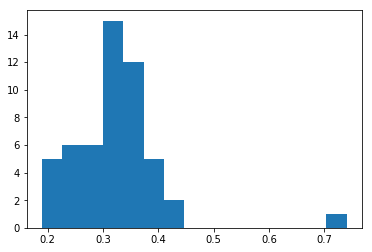

In [73]:
plt.hist(pd.DataFrame(list(state_win_percentage.items())[1:])[1], bins=15);

In [153]:
!mv episode_df_saved.csv episode_df_saved_backup.csv
episodes.to_csv('episode_df_saved.csv', sep='¤')
!rm episode_df_saved_backup.csv

In [152]:
episodes = episodes.loc[:,['season', 'show_num', 'date', 'weekday',
                          'comments', 'question_num','round',
                          'category', 'difficulty', 'question', 'answer', 'DD', 
                          'c1', 'c1_add', 'c1_cumsum', 'c1_job', 'c1_loc', 'c1_state',
                          'c2', 'c2_add', 'c2_cumsum', 'c2_job', 'c2_loc', 'c2_state',
                          'c3', 'c3_add', 'c3_cumsum', 'c3_job', 'c3_loc', 'c3_state',
                          'winner', 'winner_loc', 'winner_state', 'winner_winnings']]

In [155]:
unique_jobs = list(zip(*np.unique([x.replace(', ', ',') 
                                   for x in 
                                   episodes.groupby('show_num')[['c1_job', 'c2_job',
                                                                 'c3_job']].first().values.ravel('K')], 
                                  return_counts=True)))

In [156]:
unique_jobs.sort(key=operator.itemgetter(1), reverse=True)

In [157]:
job_types = {('education_job', 1): ['student', 'teacher', 'professor', 'phd', 'ph.d.', 'freshman', 'junior$', 
                                  'sophomore', 'senior$', 'librarian', 'university', 'college', 'tutor', 'educat'],
             ('management_job', 2): ['manag', 'executive', 'director', 'producer', 'owner', 'president', 'supervisor'],
             ('legal_job', 3): ['law', 'legal', 'attorney', 'prosecut', 'litigat', 'legislat', 'defender'],
             ('analyst_job', 4): ['analyst', 'underwriter', 'actuary', 'supply chain', 'accountant', 
                                'consultant', 'econom', 'data'],
             ('writing_job', 5): [r'(?<!under)writer', 'author', 'editor', 'journalist', 'newspaper', 'novel'],
             ('computer_job', 6): ['software', 'web', 'network', r'^it ', r'^i.t.', 'computer', 'programmer'],
             ('medical_job', 7): ['physician', 'doctor', 'pharmac', 'nurse', 'veterin', 'pediat',
                                  'psychiatr', 'psycholog', 'medic', 'health', 'cardiol',
                                  'dietician', 'surge'],
             ('homemaker', 8): ['homemaker', 'stay-at-home', 'housewife'],
             ('kid', 9): ['year-old', 'grader'],
             ('service_job',10): ['assistant', 'bartender', 'bookseller', 'social work', 'waiter', 'waitress',
                                  'secretary', 'sales', 'service', 'attend'],
             ('science_job', 11): ['research', 'scien', 'astronomer', r'(?<!psycho)logist', 'engineer'],
             ('creative_job', 12): ['chef', 'act', 'composer', 'graphic', 'design', 'art', 'culinary', 
                                     'music', 'architect',],
             ('government_job', 13): ['firefighter', 'officer', 'letter carrier', 'mail', 'government'],
             ('religious_job', 14): ['pastor', r'^minist', ' minist', 'priest',],
             ('real_estate', 15): ['realt', 'real estate']
             }

In [158]:
def assign_job_category(jobs: List[Tuple[str, int]], job_cats: Dict[str, List[str]]) -> Dict[str, str]:
    '''Given a dict with job category key words and relevant substring list values, match each unique job
    to a category'''
    jobs = jobs.copy()
    job_dict = {}
    for key in sorted(list(job_cats.keys()),key=lambda x: x[1]):
        job_match = [any(re.search(word, j[0].lower()) for word in job_cats[key]) for j in jobs]
        job_dict.update({j[0]: key[0] for i,j in enumerate(jobs) if job_match[i]})
        jobs = [j for i,j in enumerate(jobs) if not job_match[i]]
    job_dict.update({j[0]: 'Other' for j in jobs if j[0] != ''})
    job_dict.update({j[0]: '' for j in jobs if j[0] == ''})
    return job_dict

In [159]:
job_cat_dict = assign_job_category(unique_jobs, job_types)

In [160]:
for i in range(1,4):
    episodes['c{}_job_category'.format(i)] = [job_cat_dict[job.replace(', ', ',')] for job in episodes['c{}_job'.format(i)]]

In [161]:
for i in range(1,4):
    episodes['c{}_answer'.format(i)] = ['right' if value>0 else 'wrong' if value<0 else 'neither' 
                                        for value in episodes['c{}_add'.format(i)]]

In [162]:
episodes['winner_job_category'] = [episodes.loc[i,winner+'_job_category'] for i, winner in enumerate(episodes['winner'])]

In [163]:
job_category_win_counts = episodes['show_num'].groupby(episodes['show_num']).first()\
.groupby(episodes['winner_job_category']).count().reset_index(name='count')

In [164]:
job_category_counts = pd.DataFrame(list(zip(*np.unique(episodes[['c{}_job_category'.format(i) 
                                                    for i in range(1,4)]].groupby(episodes['show_num']).first().values.ravel('K'),
                                          return_counts=True))), columns = ('job_category', 'count'))

In [165]:
job_cat_counts = pd.merge(job_category_counts, job_category_win_counts, left_on='job_category', right_on='winner_job_category',
        suffixes=['', '_win']).drop('winner_job_category', axis=1)

In [166]:
job_cat_counts['percentage'] = job_cat_counts.count_win/job_cat_counts['count']

In [167]:
#Calculations to get how many right/wrong/neither answers each contestant had per show
contestant_num_right = pd.melt(episodes[['show_num'] + ['c{}_answer'.format(i) for i in range(1,4)]], id_vars='show_num', var_name='contestant',
       value_name='answer').reset_index().groupby(['show_num', 'contestant', 'answer']).count()

In [168]:
contestant_percent_right = contestant_num_right.groupby(level=[0,1]).apply(lambda x: x / x.sum()).unstack().unstack()

In [169]:
contestant_percent_right.columns = [col[2].split('_')[0] + '_' + col[1] 
                                    for col in contestant_percent_right.columns.values]

In [170]:
contestant_percent_right = contestant_percent_right.reset_index()

In [171]:
episodes = pd.merge(episodes,
                    contestant_percent_right, 
                    on='show_num', 
                    suffixes=['','_y'])

In [172]:
episodes.loc[:,['c{}_neither'.format(i) for i in range(1,4)] + \
         ['c{}_right'.format(i) for i in range(1,4)] + \
         ['c{}_wrong'.format(i) for i in range(1,4)]] = \
episodes.loc[:,['c{}_neither'.format(i) for i in range(1,4)] + \
         ['c{}_right'.format(i) for i in range(1,4)] + \
         ['c{}_wrong'.format(i) for i in range(1,4)]].replace('', np.nan, regex=True)
episodes.loc[:,['c{}_neither'.format(i) for i in range(1,4)] + \
         ['c{}_right'.format(i) for i in range(1,4)] + \
         ['c{}_wrong'.format(i) for i in range(1,4)]] = \
episodes.loc[:,['c{}_neither'.format(i) for i in range(1,4)] + \
         ['c{}_right'.format(i) for i in range(1,4)] + \
         ['c{}_wrong'.format(i) for i in range(1,4)]].fillna(0)

In [ ]:
#This next section is focusing on me actually just working with a stacked dataframe instead of trying to finagle
#my way around the wide dataframe with c1,c2,c3 etc. My fears of a triply long dataframe have been overcome by my
#annoyance over this issue

In [174]:
prestack = episodes.copy().groupby('show_num')[[x for x in episodes.columns if re.search(r'c\d', x)]].first()

In [173]:
!mv episode_df_saved.csv episode_df_saved_backup.csv
episodes.to_csv('episode_df_saved.csv', sep='¤')
!rm episode_df_saved_backup.csv

In [3]:
episodes = pd.read_csv('episode_df_saved.csv', sep='¤', engine='python')
episodes.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
episodes.fillna('', inplace=True)

In [5]:
episodes['date'] = pd.to_datetime(episodes['date'])

In [42]:
episodes[episodes['category']=='CHINESE HISTORY']['answer'].iloc[0]

'yellow'

In [13]:
season_count = episodes['season'].unique().shape[0]

In [14]:
clue_count = defaultdict(lambda : [0]*season_count)

In [15]:
answer_count = defaultdict(lambda : [0]*season_count)
phrase_count = defaultdict(lambda : [0]*season_count)

In [16]:
stopWords = set(stopwords.words('english'))
stopWords.update(["''", "``", "'s"] + [x for x in ',():;&%$#@!0987654321[]\/?><.~'])
for season in range(1,season_count+1):
    for _,ep in episodes[episodes['season']==season].iterrows():
        for token in set(word_tokenize(ep['question'])): #needs to be set because counting clue appearance only
            if not token.lower() in stopWords:
                clue_count[token.lower()][season-1] += 1

In [98]:
for season in range(1,season_count+1):
    for i,ep in episodes[episodes['season']==season].iterrows():
        for token in word_tokenize(ep['answer']):
            if not token.lower() in stopWords:
                answer_count[token.lower()][season-1] += 1

In [106]:
for season in range(1,season_count+1):
    for i,ep in episodes[episodes['season']==season].iterrows():
        answer_count[ep['answer']][season-1] += 1

In [17]:
season_clue_words = [sum(word[i] for word in list(clue_count.values())) for i in range(0,season_count)]
#season_answer_words = [sum(word[i] for word in list(answer_count.values())) for i in range(0,season_count)]
#season_phrase_words = [sum(word[i] for word in list(phrase_count.values())) for i in range(0,season_count)]

In [18]:
season_clue_count = episodes.groupby('season')['question'].count().values

In [18]:
question_word_count = [len(question.split(' ')) for question in episodes['question']]

In [19]:
word_frequency = {word: [count/season_total 
                         for count, season_total 
                         in zip(counts, season_clue_count)]
                 for word, counts in clue_count.items()}

In [20]:
word_list = ['trump', 'obama', 'internet', 'one', 'crew', 'internet', 'texting']
word_list_df = pd.DataFrame(index=np.arange(0, len(word_list)), 
                            columns = ['word'] + \
                            ['season{}'.format(i) for i in range(1,season_count+1)] + \
                            ['season{}_total'.format(i) for i in range(1,season_count+1)])
for i, word in enumerate(word_list):
    word_list_df.loc[i] = [word] + [count for count in clue_count[word]] + list(season_clue_count)

In [21]:
word_list_df.to_csv('clue_word_list.csv')

In [34]:
episodes['question_word_count'] = question_word_count

In [169]:
#For popular word section
pd.DataFrame([(i+1, count) for i,count in enumerate(season_clue_count)], 
             columns=['season', 'count']).to_csv('season_word_count.csv', index=False)

season_timeframes = pd.DataFrame()
season_timeframes['season'] = episodes.copy().groupby('season').first()['date'].index
season_timeframes['start_date'] = episodes.copy().groupby('season').first()['date'].values
season_timeframes['end_date'] = episodes.copy().groupby('season').last()['date'].values
season_timeframes.to_csv('season_timeframes.csv', index=False)

In [101]:
biggest_spikes = word_increases(word_frequency, end_step_size=33)[0:250]

In [153]:
word_totals = {word: np.sum(count)/ for word, count in word_frequency.items()}

In [70]:
[i+1 for i,freq in enumerate(word_frequency['trumpeter']) if freq*10000>6]

[7]

In [ ]:
[category for category in episodes[episodes['season']==21]['category'].unique()]

In [80]:
[category for category in episodes[episodes['season']==21]['category'].unique()
 if any('Trump' in question 
        for question in episodes[(episodes['season']==21) & (episodes['category']==category)]['question'])]

['BUSINESS',
 'NONFICTION',
 'MANHATTAN NEIGHBORHOODS',
 'KIDDIE LIT',
 'TUXEDO JUNCTION',
 'BOOK TITLES',
 'DONALD TRUMP']

In [67]:
biggest_clue_spikes = biggest_spikes[0:1000]
del biggest_spikes

In [178]:
values = [('name', ['c{}'.format(i) for i in range(1,4)]),
          ('add', ['c{}_add'.format(i) for i in range(1,4)]),
          ('cumsum', ['c{}_cumsum'.format(i) for i in range(1,4)]),
          ('job', ['c{}_job'.format(i) for i in range(1,4)]),
          ('loc', ['c{}_loc'.format(i) for i in range(1,4)]),
          ('state', ['c{}_state'.format(i) for i in range(1,4)]),
          ('job_category', ['c{}_job_category'.format(i) for i in range(1,4)]),
          ('answered', ['c{}_answer'.format(i) for i in range(1,4)]),
          ('percent_right', ['c{}_right'.format(i) for i in range(1,4)]),
          ('percent_wrong', ['c{}_wrong'.format(i) for i in range(1,4)]),
          ('percent_neither', ['c{}_neither'.format(i) for i in range(1,4)])]

In [179]:
melted_dataframes = [pd.melt(episodes.copy(), 
                id_vars=[x for x in episodes.columns if not re.search(r'c\d', x)], 
                value_vars=val[1], var_name='contestant', 
                value_name=val[0]) for val in values]

In [180]:
for df in melted_dataframes:
    df['contestant'] = df.contestant.str.slice(0,2)

In [181]:
stacked_eps = reduce(lambda left,right: pd.merge(left,right,on=['contestant'] + \
                                                 [x for x in episodes.columns 
                                                  if not re.search(r'c\d', x)]), melted_dataframes)

In [182]:
stacked_eps['percent_attempted_correct'] = \
stacked_eps['percent_right'] / (stacked_eps['percent_right'] + stacked_eps['percent_wrong'])

In [183]:
fj_diffs = stacked_eps.groupby(['show_num', 'contestant']).nth(-1)['add']

In [184]:
before_fj_score = stacked_eps.groupby(['show_num', 'contestant']).nth(-2)['cumsum']

In [185]:
stacked_eps = pd.merge(stacked_eps, 
                       pd.DataFrame(abs(fj_diffs/before_fj_score), 
                                    columns=['fj_wager_percentage']).reset_index().replace(np.inf, 0).replace(-np.inf,0), 
                       on=['show_num', 'contestant'])

In [186]:
stacked_eps['date'] = pd.to_datetime(stacked_eps['date'])

In [187]:
stacked_eps['DD1'] = False #Round 1 Daily Double
stacked_eps['DD2'] = False #Double Jeopardy First Daily Double
stacked_eps['DD3'] = False #Double Jeopardy Second Daily Double

In [188]:
stacked_eps.loc[(stacked_eps['DD']) & \
            (stacked_eps['round']=='jeopardy_round'),'DD1'] = True

In [189]:
DD2 = stacked_eps.copy()[(stacked_eps['DD']) & \
            (stacked_eps['round']=='double_jeopardy_round')]\
.sort_values(by=['show_num', 'question_num']).groupby('show_num', as_index=False, sort=False)\
['question_num',].first()

In [190]:
DD2_index = DD2.set_index(['show_num', 'question_num']).index
whole_index = stacked_eps.set_index(['show_num', 'question_num']).index

In [191]:
stacked_eps.loc[whole_index.isin(DD2_index),'DD2'] = True

In [192]:
DD3 = stacked_eps.copy()[(stacked_eps['DD']) & \
            (stacked_eps['round']=='double_jeopardy_round')]\
.sort_values(by=['show_num', 'question_num']).groupby('show_num', as_index=False, sort=False)\
[['question_num',]].last()

In [193]:
DD3_index = DD3.set_index(['show_num', 'question_num',]).index

In [194]:
stacked_eps.loc[(whole_index.isin(DD3_index)) & (~whole_index.isin(DD2_index)), 'DD3'] = True

In [195]:
for i in range(1,4):
    stacked_eps['DD{}_answered'.format(i)] = False
    DD_index = stacked_eps.loc[(stacked_eps['DD{}'.format(i)]) & \
                                (stacked_eps['answered']!='neither'),
                                ['show_num', 'contestant']]\
                          .set_index(['show_num', 'contestant']).index
    whole_index = stacked_eps.set_index(['show_num', 'contestant']).index
    stacked_eps.loc[whole_index.isin(DD_index),'DD{}_answered'.format(i)] = True 

In [196]:
stacked_eps['winner'] = stacked_eps['winner']==stacked_eps['contestant']

In [324]:
'''stacked_eps[(stacked_eps['DD1_answered']) & (stacked_eps['DD2_answered']) & (stacked_eps['DD3_answered'])\
           & ((stacked_eps['DD1'])|(stacked_eps['DD2'])|(stacked_eps['DD3']))].groupby(['winner', 'show_num', 'answered',])\
            .count().groupby(level=[0,1]).apply(lambda x: x/x.sum()).groupby(level=[0,2]).mean()'''

season      date   weekday  comments  question_num  \
winner answered                                                         
False  right     0.587879  0.587879  0.587879  0.570093      0.587879   
       wrong     0.552288  0.552288  0.552288  0.528846      0.552288   
True   right     0.742126  0.742126  0.742126  0.771984      0.742126   
       wrong     0.442006  0.442006  0.442006  0.433515      0.442006   

                    round  category  difficulty  question    answer  \
winner answered                                                       
False  right     0.587879  0.587879    0.587879  0.587879  0.587879   
       wrong     0.552288  0.552288    0.552288  0.552288  0.552288   
True   right     0.742126  0.742126    0.742126  0.742126  0.742126   
       wrong     0.442006  0.442006    0.442006  0.442006  0.442006   

                     ...       percent_wrong  percent_neither  \
winner answered      ...                                        
False  right         ...            0.587879         0.587879   
       wrong         ...            0.552288         0.552288   
True   right         ...            0.742126         0.742126   
       wrong         ...            0.442006         0.442006   

                 percent_attempted_correct  fj_wager_percentage       DD1  \
winner answered                                                             
False  right                      0.587879             0.589041  0.587879   
       wrong                      0.552288             0.551724  0.552288   
True   right                      0.742126             0.742126  0.742126   
       wrong                      0.442006             0.442006  0.442006   

                      DD2       DD3  DD1_answered  DD2_answered  DD3_answered  
winner answered                                                                
False  right     0.587879  0.587879      0.587879      0.587879      0.587879  
       wrong     0.552288  0.552288      0.552288      0.552288      0.552288  
True   right     0.742126  0.742126      0.742126      0.742126      0.742126  
       wrong     0.442006  0.442006      0.442006      0.442006      0.442006  

[4 rows x 33 columns]

In [197]:
stacked_eps[(stacked_eps['DD1_answered']) & (stacked_eps['DD2_answered']) & (stacked_eps['DD3_answered'])]\
.groupby('show_num').first().groupby('winner').count()

,season,date,weekday,comments,question_num,round,category,difficulty,question,answer,...,percent_wrong,percent_neither,percent_attempted_correct,fj_wager_percentage,DD1,DD2,DD3,DD1_answered,DD2_answered,DD3_answered
winner,,,,,,,,,,,,,,,,,,,,,
False,242,242,242,242,242,242,242,242,242,242,...,242,242,242,221,242,242,242,242,242,242
True,518,518,518,518,518,518,518,518,518,518,...,518,518,518,518,518,518,518,518,518,518


In [198]:
stacked_eps['DD_wager_percent'] = np.nan

In [199]:
DD_filter = ((stacked_eps['DD1'])&(stacked_eps['DD1_answered']))|\
            ((stacked_eps['DD2'])&(stacked_eps['DD2_answered']))|\
            ((stacked_eps['DD2'])&(stacked_eps['DD2_answered']))
stacked_eps.loc[DD_filter, 'DD_wager_percent'] = \
abs(stacked_eps.loc[DD_filter, 'add'] / (stacked_eps.loc[DD_filter, 'cumsum'] - stacked_eps.loc[DD_filter, 'add']))

In [200]:
stacked_eps[np.isinf(stacked_eps['DD_wager_percent'])] = np.nan

In [201]:
before_dd = stacked_eps.loc[DD_filter, 'cumsum'] - stacked_eps.loc[DD_filter, 'add']

In [202]:
def nov2001valuefilter(before_dd: pd.core.series.Series, higher: bool=True, post: bool=True) -> pd.core.series.Series:
    '''On November 26, 2001, the values of clues on Jeopardy were doubled. This is to account for that so that
    I'm being unbiased to contestants who could have earned less money'''
    if higher: 
        higher = operator.gt
    else:
        higher = operator.le
    if post:
        post = operator.ge
        j_val = 1000
        dj_val = 2000
    else:
        post = operator.lt
        j_val = 500
        dj_val = 1000
    
    return (((higher(before_dd,j_val) & (stacked_eps['round']=='jeopardy_round'))|\
             (higher(before_dd,dj_val) & (stacked_eps['round']=='double_jeopardy_round'))) & \
            post(stacked_eps['show_num'],3966))           

In [203]:
#JOB CATEGORY DD WAGERS
stacked_eps[DD_filter & (nov2001valuefilter(before_dd, post=False) | nov2001valuefilter(before_dd))]\
.groupby('job_category')['DD_wager_percent'].agg({'mean': 'mean', 'count': 'count'}).sort_values(by='mean')

/Users/isaac/anaconda/envs/jeopardy_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,mean,count
job_category,,
kid,0.321816,113
homemaker,0.415954,166
legal_job,0.418379,623
,0.426427,59
writing_job,0.427823,709
creative_job,0.429383,350
education_job,0.431163,2632
management_job,0.435697,752
computer_job,0.437761,322


In [51]:
#True DD for job categories
true_dd_jobs = stacked_eps[DD_filter & (nov2001valuefilter(before_dd, post=False) |\
                                        nov2001valuefilter(before_dd)) &\
                           (stacked_eps['DD_wager_percent'] > 0.9999)].groupby('job_category')['add'].count()/\
stacked_eps[DD_filter & (nov2001valuefilter(before_dd, post=False) |\
                         nov2001valuefilter(before_dd))].groupby('job_category')['add'].count()
true_dd_jobs.sort_values()

job_category
kid               0.093525
religious_job     0.100000
homemaker         0.102941
medical_job       0.109434
management_job    0.116092
service_job       0.125604
education_job     0.128413
legal_job         0.131824
writing_job       0.137441
government_job    0.138298
real_estate       0.142857
creative_job      0.143939
Other             0.147718
computer_job      0.155738
science_job       0.156627
analyst_job       0.160828
Name: add, dtype: float64

In [54]:
#STATE DD WAGERS
stacked_eps[DD_filter & (nov2001valuefilter(before_dd, post=False) | nov2001valuefilter(before_dd))]\
.groupby('state')['DD_wager_percent'].agg({'mean': 'mean', 'count': 'count'}).sort_values(by='mean')

,mean,count
state,,
North Dakota,0.373503,5
Oklahoma,0.383382,71
Utah,0.394848,119
Louisiana,0.425682,112
Rhode Island,0.426996,41
Kentucky,0.427995,115
Georgia,0.431383,257
Michigan,0.432974,219
Wyoming,0.439337,6


In [52]:
#True DD for states
true_dd_states = stacked_eps[DD_filter & (nov2001valuefilter(before_dd, post=False) |\
                                        nov2001valuefilter(before_dd)) &\
                           (stacked_eps['DD_wager_percent'] > 0.9999)].groupby('state')['add'].count()/\
stacked_eps[DD_filter & (nov2001valuefilter(before_dd, post=False) |\
                         nov2001valuefilter(before_dd))].groupby('state')['add'].count()
true_dd_states.sort_values()

state
Hawaii            0.086957
Maine             0.090909
Indiana           0.092437
Georgia           0.097276
Rhode Island      0.097561
Oklahoma          0.098592
Michigan          0.100457
Utah              0.100840
New Jersey        0.104762
Florida           0.105960
Louisiana         0.107143
South Carolina    0.112500
Nevada            0.114286
Oregon            0.114286
Tennessee         0.116883
Pennsylvania      0.117143
New Hampshire     0.117647
Iowa              0.120000
Kentucky          0.121739
California        0.122642
D.C.              0.129353
New York          0.129734
Alaska            0.130435
Wisconsin         0.131313
Virginia          0.135678
Alabama           0.139241
Ohio              0.141566
Texas             0.142433
Montana           0.142857
Maryland          0.145773
Vermont           0.147059
West Virginia     0.148148
Massachusetts     0.149367
Other             0.151203
South Dakota      0.153846
Missouri          0.155963
North Carolina    0.15

In [204]:
stacked_eps['true_DD'] = np.nan
stacked_eps.loc[DD_filter, 'true_DD'] = False

In [205]:
stacked_eps.loc[DD_filter & (nov2001valuefilter(before_dd, post=False) | nov2001valuefilter(before_dd)) &\
           (stacked_eps['DD_wager_percent']>0.999), 'true_DD'] = True

In [206]:
!mv stacked_ep_df_saved.csv stacked_ep_df_saved_backup.csv
stacked_eps.to_csv('stacked_ep_df_saved.csv', sep='¤')
#!rm stacked_ep_df_saved_backup.csv

In [43]:
stacked_eps = pd.read_csv('stacked_ep_df_saved.csv', sep='¤', engine='python')
stacked_eps.drop('Unnamed: 0', axis=1, inplace=True)

In [28]:
notnull = stacked_eps.notnull()
stacked_eps = stacked_eps.loc[notnull.mean(1)>.5,:]

In [58]:
"""Getting information for contestant winning streaks"""

'Getting information for contestant winning streaks'

In [29]:
#Adapted from https://stackoverflow.com/questions/25119524/pandas-conditional-rolling-count
#Intended to give streak counts for contestants
def rolling_id(val):
    if val != rolling_id.previous:
        rolling_id.id +=1
        rolling_id.previous = val
    return rolling_id.id
rolling_id.id = 0 #static variable
rolling_id.previous = None #static variable

In [30]:
def next_ep(val):
    if next_ep.next - val ==1:
        next_ep.truth = 1
    else:
        next_ep.truth = 0
    next_ep.next = val
    return next_ep.truth
next_ep.truth = 0
next_ep.next = 0

In [57]:
keys = ['show_num', 'state']
i1 = stacked_eps.set_index(keys).index
i2 = two_show_nums.set_index(keys).index

In [59]:
stacked_eps['win_weight'] = 1
stacked_eps.loc[i1.isin(i2), 'win_weight'] = 0.5
stacked_eps.loc[stacked_eps['show_num'].isin(allstate_shownums), 'win_weight'] = 0

In [86]:
stacked_eps['next_weight'] = list(stacked_eps.iloc[1:]['win_weight'].copy()) + [1]

In [31]:
stacked_eps.comments.fillna('', inplace=True)

In [32]:
not_special_week = [all(word not in comment for word in ['tournament', 'championship', 'kid']) for comment in stacked_eps['comments'].str.lower()]

In [34]:
consec_ep_index = stacked_eps.loc[((stacked_eps['winner']==1) & (not_special_week)), ['name', 'show_num']]\
.groupby('show_num', as_index=False).first().sort_values('show_num', ascending=False)['show_num']

In [35]:
consec_ep = stacked_eps.loc[((stacked_eps['winner']==1) & (not_special_week)), ['name', 'show_num']]\
.groupby('show_num', as_index=False).first().sort_values('show_num', ascending=False)['show_num'].apply(next_ep)

In [36]:
consec_ep = consec_ep.to_frame().set_index(consec_ep_index)

In [37]:
consec_ep.columns = ['consecutive']

In [38]:
consec_ep = consec_ep.reset_index()

In [39]:
stacked_eps = pd.merge(stacked_eps,
                      consec_ep,
                      on='show_num',
                      how='left')

In [40]:
streaks = pd.DataFrame(stacked_eps.loc[((stacked_eps['winner']==1) & (not_special_week)), ['name', 'show_num']]\
                       .groupby('show_num').first()['name'].apply(rolling_id))
streaks.columns = ['streaks']
streaks.reset_index(inplace=True)

In [41]:
not_special_df = stacked_eps[((stacked_eps['winner']==1) & \
             ([not x for x in not_special_week]))]\
.groupby('show_num', as_index=False).first()['show_num'].to_frame()

In [42]:
not_special_df['streaks'] = list(range(streaks['streaks'].max()+1,streaks['streaks'].max() + len(not_special_df)+1))

In [43]:
streaks = pd.concat([streaks, not_special_df])

In [44]:
stacked_eps = pd.merge(stacked_eps,
                      streaks,
                      on='show_num',
                      how='left')

In [45]:
stacked_eps['streaks'].fillna(1, inplace=True)

In [87]:
streak_agg = {'show_num': ['nunique', 'last'], 'state': ['first'], 
              'consecutive': ['last'], 'win_weight': ['last'],
              'next_weight': ['last']}

In [148]:
winner_counts = stacked_eps[((stacked_eps['winner']==1)&stacked_eps['show_num'].isin(sep_show_nums))]\
.groupby('streaks', as_index=False)['show_num', 'state', 'consecutive', 'win_weight', 'next_weight']\
.agg(streak_agg).copy()

In [149]:
winner_counts.columns = ['streak_id', 'count', 'show_num', 'state', 'consecutive', 'win_weight', 'next_weight']

In [150]:
redundancy_agg = {'consecutive': ['sum'], 
                 'next_weight': ['mean']}

In [151]:
redundancies = winner_counts[winner_counts['consecutive']==1].groupby('state').agg(redundancy_agg)[['consecutive', 'next_weight']]

In [152]:
redundancies.columns = ['consecutive', 'next_weight']

In [153]:
redundancies['consecutive'] = redundancies['consecutive']*redundancies['next_weight']

In [154]:
winner_counts.loc[(winner_counts['win_weight']!=1) & (winner_counts['count']>1), 'win_weight'] = 1

In [155]:
winner_aggs = {'count': ['count'], 'win_weight': ['mean']}

In [156]:
winner_counts = winner_counts.groupby('state', as_index=False).agg(winner_aggs)[['state', 'count', 'win_weight']]

In [157]:
winner_counts.columns = ['state', 'winner_count', 'win_weight']

In [158]:
winner_counts['winner_count'] = winner_counts['winner_count']*winner_counts['win_weight']
winner_counts.drop('win_weight', axis=1, inplace=True)

In [159]:
loser_counts = stacked_eps[stacked_eps['winner']==0].copy()

In [160]:
loser_counts = loser_counts.groupby(['show_num', 'name'], as_index=False).first()

In [161]:
loser_agg = {'streaks': ['count'], 'win_weight': ['mean']}

In [162]:
loser_counts = loser_counts.groupby('state').agg(loser_agg)[['streaks', 'win_weight']].reset_index()

In [163]:
loser_counts.columns = ['state', 'loser_count', 'weight']

In [164]:
loser_counts['loser_count'] = (loser_counts['loser_count']*loser_counts['weight']) - redundancies['consecutive'].values

In [165]:
loser_counts.drop('weight', axis=1, inplace=True)

In [166]:
state_percentages = pd.merge(winner_counts, loser_counts, on='state')

In [167]:
state_percentages.set_index('state', inplace=True)
state_percentages = state_percentages['winner_count']/(state_percentages['winner_count'] + state_percentages['loser_count'])

In [168]:
streak_info = stacked_eps[((stacked_eps['winner']==1)&not_special_week)].groupby('streaks', as_index=False)['show_num', 'state'].agg(streak_agg).copy()

In [169]:
streak_info.columns = ['streak_id', 'count', 'show_num', 'state', 'consecutive', 'weight', 'next_weight']

In [170]:
streak_info = streak_info.groupby('state').mean()['count']

In [171]:
state_winner_info = pd.merge(state_percentages.to_frame(), streak_info.to_frame(), left_index=True, right_index=True, how='right')

In [172]:
state_winner_info.columns = ['rate', 'streak']

In [173]:
"""Taken from https://gist.githubusercontent.com/meiqimichelle/7727723/raw/0109432d22f28fd1a669a3fd113e41c4193dbb5d/USstates_avg_latLong"""
longs_and_lats = pd.read_json('longs_and_lats.json')

In [174]:
pd.merge(longs_and_lats, state_winner_info.reset_index(), on='state').to_csv('state_win_rates.csv')

In [180]:
state_winner_info.sort_values('rate', ascending=False, inplace=True)
state_winner_info['rate_rank'] = list(range(1,len(state_winner_info)+1))
state_winner_info.sort_values('streak', ascending=False, inplace=True)
state_winner_info['streak_rank'] = list(range(1,len(state_winner_info)+1))
state_winner_info['total_rank'] = state_winner_info['rate_rank'] + state_winner_info['streak_rank']
state_winner_info.sort_values('total_rank', inplace=True)

In [ ]:
"""---------------------------------------------"""

In [5]:
stacked_eps['num_DD'] = sum(stacked_eps['DD{}_answered'.format(i)] for i in range(1,4))

In [186]:
mean_state_values = stacked_eps.groupby(['show_num', 'contestant'], as_index=False).first().groupby('state').mean()

In [187]:
mean_job_values = stacked_eps.groupby(['show_num', 'contestant'], as_index=False).first().groupby('job_category').mean()

In [188]:
top_25_r1_cats = episodes[episodes['round']=='jeopardy_round'].groupby(['season', 'show_num', 'category'], as_index=False)\
.first()['category'].value_counts().index[0:25]

In [189]:
r1_cats_right = []
for cat in top_25_r1_cats:
    r1_cats_right.append((cat, stacked_eps[(stacked_eps['round']=='jeopardy_round') & (stacked_eps['category']==cat)]\
    .groupby(['show_num', 'question_num']).agg({'answered': lambda x: sum(x=='right')}).sum()/\
    stacked_eps[(stacked_eps['round']=='jeopardy_round') & (stacked_eps['category']==cat)]\
    .groupby(['show_num','question_num']).first().count()['season']))

In [190]:
top_25_r2_cats = episodes[episodes['round']=='double_jeopardy_round'].groupby(['season', 'show_num', 'category'], as_index=False)\
.first()['category'].value_counts().index[0:25]

In [191]:
r2_cats_right = []
for cat in top_25_r2_cats:
    r2_cats_right.append((cat, stacked_eps[(stacked_eps['round']=='double_jeopardy_round') & (stacked_eps['category']==cat)]\
    .groupby(['show_num', 'question_num']).agg({'answered': lambda x: sum(x=='right')}).sum()/\
    stacked_eps[(stacked_eps['round']=='double_jeopardy_round') & (stacked_eps['category']==cat)]\
    .groupby(['show_num','question_num']).first().count()['season']))

In [212]:
cat_question_count = stacked_eps[(stacked_eps['contestant']=='c1') & \
                                 (stacked_eps['round']!='final_jeopardy_round')]['category']\
.value_counts().sort_index()

In [213]:
num_answered = stacked_eps[stacked_eps['round']!='final_jeopardy_round'].groupby(['show_num', 'category', 'question_num'], as_index=False)\
.agg({'answered': lambda x: sum(x=='right')})

In [214]:
cat_right_count = num_answered.groupby('category', as_index=False)\
                    .agg({'answered': lambda x: sum(x>0)}).sort_values(by='category')

In [215]:
cat_percent_right = cat_right_count['answered'].values / cat_question_count.values

In [216]:
cat_percent_right = pd.DataFrame(cat_percent_right)

In [217]:
cat_percent_right.index = cat_question_count.index

In [218]:
cat_percent_right.columns = ['percent_right']

In [219]:
cat_percent_right['count'] = cat_question_count.values

In [200]:
episodes[episodes['category']=='C.I.A. DIRECTORS'][['season','show_num','question', 
                                                    'answer', 'c1_answer', 'c2_answer', 'c3_answer']]

,season,show_num,question,answer,c1_answer,c2_answer,c3_answer
299786,31,6931,An Air Force base on California's Central Coas...,Hoyt Vandenberg,neither,neither,wrong
299787,31,6931,"Appointed by Gerald Ford, he's the only man to...",George H.W. Bush,wrong,neither,neither
299788,31,6931,This general resigned as director in 2012 afte...,David Petraeus,neither,neither,neither
299793,31,6931,"Once President Clinton's Chief of Staff, he se...",Leon Panetta,neither,neither,neither
299795,31,6931,This brother of John Foster Dulles resigned as...,Allen Dulles,neither,neither,neither


In [223]:
cat_percent_right.sort_values(by=['percent_right', 'count'], ascending=[True,False]).head(50)

,percent_right,count
C.I.A. DIRECTORS,0.0,5
CENTRAL AMERICAN CAPITALS,0.0,5
COMMOND BONDS,0.0,5
GIVE THE ORDER,0.0,5
QUOTABLE OSCAR HOSTS,0.0,5
STAR TREK: VOYAGER,0.0,5
ALFRED HITCHCOCK RESENTS,0.0,4
ECUADOR OF YORE,0.0,4
QUEEN'S BIRTHDAY HONOURS 2000,0.0,4
SCRAMBLED HARRY POTTER CHARACTERS,0.0,4


In [86]:
mean_state_values.sort_values(by='percent_attempted_correct')

,show_num,season,question_num,DD,winner_winnings,add,cumsum,percent_right,percent_wrong,percent_neither,percent_attempted_correct
state,,,,,,,,,,,
Hawaii,4275.860000,19.060000,1.0,0.000000,18163.020000,22.000000,22.000000,0.239624,0.060010,0.700366,0.791646
Wyoming,4741.071429,20.928571,1.0,0.000000,19728.714286,64.285714,64.285714,0.238004,0.058337,0.703659,0.794137
Rhode Island,4586.924242,20.484848,1.0,0.015152,17686.560606,48.484848,48.484848,0.264044,0.061401,0.674555,0.802296
New Mexico,4698.640000,20.920000,1.0,0.000000,17170.380000,38.000000,38.000000,0.259854,0.060107,0.680039,0.807979
Alabama,5076.248000,22.616000,1.0,0.000000,16799.808000,84.800000,84.800000,0.278449,0.064021,0.657530,0.810383
Nevada,4420.757143,19.685714,1.0,0.000000,18346.571429,34.285714,34.285714,0.268372,0.057598,0.674030,0.815687
Maine,4493.877193,20.105263,1.0,0.000000,17393.052632,38.596491,38.596491,0.261910,0.055024,0.683066,0.817560
Wisconsin,4735.228070,21.122807,1.0,0.000000,16818.760234,42.690058,42.690058,0.276011,0.058184,0.665804,0.819236
North Carolina,5239.417544,23.350877,1.0,0.003509,17921.950877,55.789474,55.789474,0.271639,0.054107,0.674254,0.820952


In [68]:
unique_locs = list(zip(*np.unique([x.replace(', ', ',') 
                                   for x in 
                                   episodes.groupby('show_num')[['c1_loc', 'c2_loc',
                                                                 'c3_loc', 'c4_loc']].first().values.ravel('K')], 
                                  return_counts=True)))

In [69]:
unique_locs.sort(key=operator.itemgetter(1), reverse=True)

In [75]:
state_locs = list(itertools.compress(list(zip(*unique_locs))[0],
                                     [state and not uni and not the 
                                      for state, uni, the in zip(has_state,has_uni, has_the)]))

In [77]:
scores_by_season = episodes.groupby('show_num').last().set_index('season')[['c{}_cumsum'.format(i) for i in range(1,4)]]
mean_scores_by_season = scores_by_season.stack().groupby(level=0).mean().values
score_se_by_season = scores_by_season.stack().groupby(level=0).apply(sem).values

In [78]:
plt.figure(figsize=(12,9));

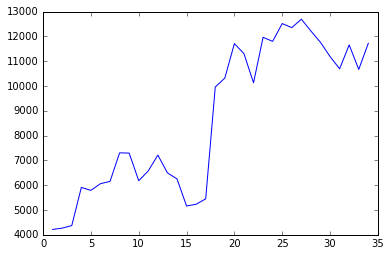

In [79]:
plt.plot(episodes.season.unique(), mean_scores_by_season);

In [1198]:
aggregations = {
    'stumper': lambda x: sum(x>0)
}

In [1219]:
#Working on seeing how many questions are answered wrong/right per contestant
stumpers = episodes.set_index(['season', 'show_num', 'question_num'])[['c{}_add'.format(i) for i in range(1,5)]].stack().groupby(level=[0,1,2]).agg(aggregations)

In [1221]:
stumpers2 = stumpers.groupby(level=[0,1])['stumper'].agg({'stumpers': lambda x: sum(x==0)/x.count()})

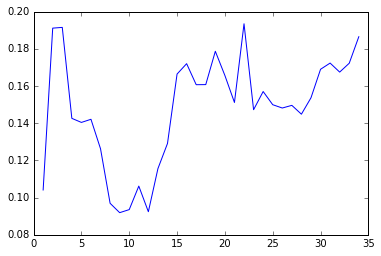

In [1225]:
plt.plot(stumpers2.groupby(level=0)['stumpers'].mean().index,stumpers2.groupby(level=0)['stumpers'].mean().values)

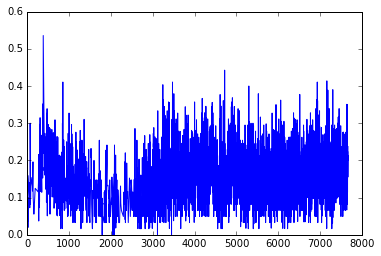

In [1214]:
plt.plot(stumpers2.index, stumpers2.values)